## Task 1 Part e)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for matplotlib visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# --- STEP 1: DATA LOADING ---
def load_data(file_path):
    """
    Load the dataset based on file extension
    Supports CSV, Excel, and JSON formats
    """
    file_extension = file_path.split('.')[-1].lower()
    
    if file_extension == 'csv':
        df = pd.read_csv(file_path, low_memory=False)
    elif file_extension in ['xls', 'xlsx']:
        df = pd.read_excel(file_path)
    elif file_extension == 'json':
        df = pd.read_json(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    print(f"Dataset loaded with shape: {df.shape}")
    return df

# --- STEP 2: DATA CLEANING AND PREPROCESSING ---
def clean_data(df):
    """
    Basic data cleaning operations
    """
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Display initial info
    print("\n----- INITIAL DATA INFO -----")
    print(f"Rows: {df_clean.shape[0]}, Columns: {df_clean.shape[1]}")
    print("\nColumn Data Types:")
    print(df_clean.dtypes)
    
    print("\nMissing Values (before cleaning):")
    missing_values = df_clean.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # Fix column names - remove spaces, special chars, make lowercase
    df_clean.columns = [col.lower().replace(' ', '_').replace('-', '_') for col in df_clean.columns]
    
    # Remove duplicate rows
    initial_rows = df_clean.shape[0]
    df_clean = df_clean.drop_duplicates()
    dropped_rows = initial_rows - df_clean.shape[0]
    print(f"\nRemoved {dropped_rows} duplicate rows")
    
    # Handle missing values - this is a basic strategy, you may adjust based on your dataset
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    
    # For numeric columns, replace NAs with median
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            print(f"Filled NAs in '{col}' with median: {median_value}")
    
    # For categorical columns, replace NAs with mode
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_value = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_value, inplace=True)
            print(f"Filled NAs in '{col}' with mode: {mode_value}")
    
    # Check for outliers in numeric columns using IQR method
    print("\nChecking for outliers in numeric columns:")
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].shape[0]
        if outliers > 0:
            print(f"Column '{col}' has {outliers} outliers")
    
    # Convert date columns to datetime if they exist
    for col in df_clean.columns:
        if any(date_hint in col.lower() for date_hint in ['date', 'year', 'month', 'time']):
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
                print(f"Converted '{col}' to datetime")
            except:
                pass
    
    print("\nMissing Values (after cleaning):")
    missing_after = df_clean.isnull().sum()
    print(missing_after[missing_after > 0])
    
    return df_clean

# --- STEP 3: EXPLORATORY DATA ANALYSIS ---
def exploratory_data_analysis(df):
    """
    Perform basic exploratory data analysis
    """
    print("\n----- EXPLORATORY DATA ANALYSIS -----")
    
    # Summary statistics for numeric columns
    print("\nSummary Statistics:")
    print(df.describe().T)
    
    # Frequency counts for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("\nFrequency Counts for Categorical Variables:")
        for col in categorical_cols[:5]:  # Limit to first 5 to avoid long output
            print(f"\n{col}:")
            value_counts = df[col].value_counts().head(10)
            print(value_counts)
    
    # Check for correlations between numeric variables
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 1:
        print("\nCorrelation Matrix:")
        correlation_matrix = df[numeric_cols].corr()
        print(correlation_matrix.round(2))
        
        # Identify strong correlations
        strong_correlations = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > 0.7:
                    strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
        
        if strong_correlations:
            print("\nStrong Correlations (>0.7 or <-0.7):")
            for var1, var2, corr in strong_correlations:
                print(f"{var1} and {var2}: {corr:.2f}")
    
    return None

# --- STEP 4: DATA VISUALIZATION ---
def create_visualizations(df, output_dir=None):
    """
    Create various visualizations based on data types
    """
    print("\n----- DATA VISUALIZATION -----")
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    # Limit to fewer columns for visualization
    if len(numeric_cols) > 5:
        numeric_cols = numeric_cols[:5]
    if len(categorical_cols) > 5:
        categorical_cols = categorical_cols[:5]
    
    # 1. Distribution of numeric variables
    if len(numeric_cols) > 0:
        print("\nCreating distribution plots for numeric variables...")
        
        # Using matplotlib/seaborn
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_cols):
            plt.subplot(len(numeric_cols), 2, 2*i+1)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
            
            plt.subplot(len(numeric_cols), 2, 2*i+2)
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(f"{output_dir}/numeric_distributions.png")
        plt.show()
        
        # Using Plotly for interactive plots
        for col in numeric_cols:
            fig = make_subplots(rows=1, cols=2,
                               subplot_titles=[f'Histogram of {col}', f'Box Plot of {col}'])
            
            fig.add_trace(go.Histogram(x=df[col], name='Histogram', opacity=0.7), row=1, col=1)
            fig.add_trace(go.Box(x=df[col], name='Box Plot'), row=1, col=2)
            
            fig.update_layout(title=f'Distribution Analysis of {col}',
                             height=500, width=900)
            fig.show()
    
    # 2. Bar charts for categorical variables
    if len(categorical_cols) > 0:
        print("\nCreating bar charts for categorical variables...")
        
        for col in categorical_cols:
            # Get top categories (limit to 10)
            value_counts = df[col].value_counts().head(10)
            
            # Using matplotlib/seaborn
            plt.figure(figsize=(12, 6))
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Top Categories in {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            if output_dir:
                plt.savefig(f"{output_dir}/categorical_{col}.png")
            plt.show()
            
            # Using Plotly
            fig = px.bar(x=value_counts.index, y=value_counts.values, 
                        title=f'Top Categories in {col}',
                        labels={'x': col, 'y': 'Count'})
            fig.update_layout(xaxis_tickangle=-45)
            fig.show()
    
    # 3. Correlation Heatmap for numeric variables
    if len(numeric_cols) > 1:
        print("\nCreating correlation heatmap...")
        
        correlation_matrix = df[numeric_cols].corr()
        
        # Using matplotlib/seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        if output_dir:
            plt.savefig(f"{output_dir}/correlation_heatmap.png")
        plt.show()
        
        # Using Plotly
        fig = go.Figure(data=go.Heatmap(
                        z=correlation_matrix.values,
                        x=correlation_matrix.columns,
                        y=correlation_matrix.index,
                        colorscale='RdBu_r',
                        zmin=-1, zmax=1))
        
        fig.update_layout(title='Correlation Matrix',
                         height=600, width=700)
        fig.show()
    
    # 4. Scatter plots for pairs of numeric variables with strong correlation
    if len(numeric_cols) > 1:
        print("\nCreating scatter plots for correlated variables...")
        
        # Find pairs with correlation > 0.5 or < -0.5
        strong_pairs = []
        for i in range(len(numeric_cols)):
            for j in range(i+1, len(numeric_cols)):
                corr = df[numeric_cols[i]].corr(df[numeric_cols[j]])
                if abs(corr) > 0.5:
                    strong_pairs.append((numeric_cols[i], numeric_cols[j], corr))
        
        # Plot up to 3 pairs
        for pair_idx, (var1, var2, corr) in enumerate(strong_pairs[:3]):
            # Using matplotlib/seaborn
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=df[var1], y=df[var2])
            plt.title(f'Scatter Plot: {var1} vs {var2} (Corr: {corr:.2f})')
            plt.tight_layout()
            if output_dir:
                plt.savefig(f"{output_dir}/scatter_{var1}_{var2}.png")
            plt.show()
            
            # Using Plotly
            fig = px.scatter(df, x=var1, y=var2, 
                           title=f'Scatter Plot: {var1} vs {var2} (Correlation: {corr:.2f})')
            fig.show()
    
    # 5. Time series plots if datetime columns exist
    if len(datetime_cols) > 0:
        print("\nCreating time series plots...")
        
        for date_col in datetime_cols:
            for num_col in numeric_cols[:2]:  # Limit to first 2 numeric columns
                # Make sure dataframe is sorted by date
                df_sorted = df.sort_values(by=date_col)
                
                # Using matplotlib/seaborn
                plt.figure(figsize=(12, 6))
                plt.plot(df_sorted[date_col], df_sorted[num_col])
                plt.title(f'Time Series: {num_col} over {date_col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                if output_dir:
                    plt.savefig(f"{output_dir}/timeseries_{num_col}.png")
                plt.show()
                
                # Using Plotly
                fig = px.line(df_sorted, x=date_col, y=num_col,
                            title=f'Time Series: {num_col} over {date_col}')
                fig.show()
    
    return None

# --- STEP 5: ADVANCED ANALYSIS AND INSIGHTS ---
def generate_insights(df):
    """
    Generate insights based on the data
    """
    print("\n----- DATA INSIGHTS -----")
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    insights = []
    
    # 1. Basic statistics insights
    if len(numeric_cols) > 0:
        # Find columns with high variance
        for col in numeric_cols:
            mean = df[col].mean()
            std = df[col].std()
            cv = std / mean if mean != 0 else 0
            
            if cv > 1:
                insights.append(f"High variability detected in '{col}' (CV = {cv:.2f}), suggesting significant spread in the data.")
        
        # Find outlier-heavy columns
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_pct = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0] / df.shape[0]
            
            if outlier_pct > 0.05:
                insights.append(f"'{col}' has a high proportion of outliers ({outlier_pct:.1%}), which may skew analysis.")
    
    # 2. Correlation insights
    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()
        
        # Strong positive correlations
        pos_corrs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if correlation_matrix.iloc[i, j] > 0.7:
                    pos_corrs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
        
        if pos_corrs:
            for var1, var2, corr in pos_corrs[:3]:  # Limit to top 3
                insights.append(f"Strong positive correlation between '{var1}' and '{var2}' (r = {corr:.2f}), suggesting these variables tend to increase together.")
        
        # Strong negative correlations
        neg_corrs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if correlation_matrix.iloc[i, j] < -0.7:
                    neg_corrs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
        
        if neg_corrs:
            for var1, var2, corr in neg_corrs[:3]:  # Limit to top 3
                insights.append(f"Strong negative correlation between '{var1}' and '{var2}' (r = {corr:.2f}), suggesting as one increases, the other tends to decrease.")
    
    # 3. Categorical data insights
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            value_counts = df[col].value_counts()
            
            # Check for dominance of a single category
            if len(value_counts) > 1 and value_counts.iloc[0] / value_counts.sum() > 0.8:
                insights.append(f"The category '{value_counts.index[0]}' heavily dominates the '{col}' variable, representing {value_counts.iloc[0] / value_counts.sum():.1%} of all values.")
            
            # Check for high cardinality
            if len(value_counts) > 100:
                insights.append(f"High cardinality detected in '{col}' with {len(value_counts)} unique values, which may complicate analysis.")
    
    # 4. Time-based insights
    if len(datetime_cols) > 0:
        for date_col in datetime_cols:
            # Check for temporal patterns
            df['year'] = df[date_col].dt.year
            df['month'] = df[date_col].dt.month
            df['day_of_week'] = df[date_col].dt.dayofweek
            
            for num_col in numeric_cols[:2]:  # Limit to first 2 numeric columns
                # Check for seasonal patterns
                monthly_avg = df.groupby('month')[num_col].mean()
                max_month = monthly_avg.idxmax()
                min_month = monthly_avg.idxmin()
                
                if max_month != min_month and monthly_avg.max() / monthly_avg.min() > 1.5:
                    insights.append(f"'{num_col}' shows seasonal patterns with highest values in month {max_month} and lowest in month {min_month}.")
                
                # Check for day-of-week patterns
                dow_avg = df.groupby('day_of_week')[num_col].mean()
                max_dow = dow_avg.idxmax()
                min_dow = dow_avg.idxmin()
                dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                
                if max_dow != min_dow and dow_avg.max() / dow_avg.min() > 1.3:
                    insights.append(f"'{num_col}' shows day-of-week patterns with highest values on {dow_names[max_dow]} and lowest on {dow_names[min_dow]}.")
            
            # Remove temporary columns
            df.drop(['year', 'month', 'day_of_week'], axis=1, inplace=True)
    
    # Print insights
    if insights:
        print("\nKey Insights Generated:")
        for i, insight in enumerate(insights, 1):
            print(f"{i}. {insight}")
    else:
        print("No significant insights were generated from this dataset.")
    
    return insights

# --- MAIN FUNCTION ---
def analyze_india_dataset(file_path, output_dir=None):
    """
    Main function to run the full analysis pipeline
    """
    print("="*50)
    print("INDIA DATA ANALYSIS PIPELINE")
    print("="*50)
    
    # Step 1: Load the data
    print("\nSTEP 1: LOADING DATA")
    df = load_data(file_path)
    
    # Step 2: Clean and preprocess the data
    print("\nSTEP 2: CLEANING AND PREPROCESSING")
    df_clean = clean_data(df)
    
    # Step 3: Perform EDA
    print("\nSTEP 3: EXPLORATORY DATA ANALYSIS")
    exploratory_data_analysis(df_clean)
    
    return df_clean


In [2]:
# Define the path to your dataset
file_path = r"C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_e\apy.csv"  # Replace with your actual file path

# Optional: Set an output directory for saving visualizations
output_dir = r"C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_e\output_india_visuals"  # Replace with your desired output directory

# Run the analysis
cleaned_data = analyze_india_dataset(file_path, output_dir)
cleaned_data

INDIA DATA ANALYSIS PIPELINE

STEP 1: LOADING DATA
Dataset loaded with shape: (246091, 7)

STEP 2: CLEANING AND PREPROCESSING

----- INITIAL DATA INFO -----
Rows: 246091, Columns: 7

Column Data Types:
State_Name        object
District_Name     object
Crop_Year          int64
Season            object
Crop              object
Area             float64
Production       float64
dtype: object

Missing Values (before cleaning):
Production    3730
dtype: int64

Removed 0 duplicate rows
Filled NAs in 'production' with median: 729.0

Checking for outliers in numeric columns:
Column 'area' has 40705 outliers
Column 'production' has 43062 outliers
Converted 'crop_year' to datetime

Missing Values (after cleaning):
Series([], dtype: int64)

STEP 3: EXPLORATORY DATA ANALYSIS

----- EXPLORATORY DATA ANALYSIS -----

Summary Statistics:


C:\Users\Rishita\AppData\Local\Temp\ipykernel_32344\674193782.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_value, inplace=True)


               count                           mean  \
crop_year     246091  1970-01-01 00:00:00.000002005   
area        246091.0                   12002.820864   
production  246091.0                  573685.490072   

                                      min                            25%  \
crop_year   1970-01-01 00:00:00.000001997  1970-01-01 00:00:00.000002002   
area                                 0.04                           80.0   
production                            0.0                           91.0   

                                      50%                            75%  \
crop_year   1970-01-01 00:00:00.000002006  1970-01-01 00:00:00.000002010   
area                                582.0                         4392.0   
production                          729.0                         6769.0   

                                      max              std  
crop_year   1970-01-01 00:00:00.000002015              NaN  
area                            8580100.0     5

,state_name,district_name,crop_year,season,crop,area,production
0,Andaman and Nicobar Islands,NICOBARS,1970-01-01 00:00:00.000002000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,1970-01-01 00:00:00.000002000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,1970-01-01 00:00:00.000002000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,1970-01-01 00:00:00.000002000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,1970-01-01 00:00:00.000002000,Whole Year,Cashewnut,720.0,165.0
...,...,...,...,...,...,...,...
246086,West Bengal,PURULIA,1970-01-01 00:00:00.000002014,Summer,Rice,306.0,801.0
246087,West Bengal,PURULIA,1970-01-01 00:00:00.000002014,Summer,Sesamum,627.0,463.0
246088,West Bengal,PURULIA,1970-01-01 00:00:00.000002014,Whole Year,Sugarcane,324.0,16250.0
246089,West Bengal,PURULIA,1970-01-01 00:00:00.000002014,Winter,Rice,279151.0,597899.0


In [5]:

output_csv_path = r"C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_e\cleaned_data.csv"  # Replace with your desired output file path
cleaned_data.to_csv(output_csv_path, index=False)


In [6]:
# --- STEP 4: OPTIMIZED DATA VISUALIZATION ---
def create_fast_visualizations(df, max_plots=3):
    """
    Create visualizations optimized for performance with large datasets
    """
    print("\n----- OPTIMIZED DATA VISUALIZATION -----")
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    # Limit columns for visualization
    numeric_cols = numeric_cols[:max_plots]
    categorical_cols = categorical_cols[:max_plots]
    
    # For large datasets, sample data for visualizations
    if df.shape[0] > 100000:
        print(f"Sampling 10,000 records for visualization from {df.shape[0]} total records")
        df_sample = df.sample(100000, random_state=42)
    else:
        df_sample = df
    
    # 1. Quicker distribution plots for numeric variables
    if len(numeric_cols) > 0:
        print("\nCreating distribution plots for key numeric variables...")
        
        # Create a single figure with multiple subplots
        fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3*len(numeric_cols)))
        
        # Handle the case where there's only one numeric column
        if len(numeric_cols) == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols):
            # Simple histogram is faster than KDE
            axes[i].hist(df_sample[col].dropna(), bins=30, alpha=0.7)
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    # 2. Simplified bar charts for categorical variables
    if len(categorical_cols) > 0:
        print("\nCreating bar charts for key categorical variables...")
        
        for col in categorical_cols:
            # Only visualize if the column has a reasonable number of categories
            n_unique = df[col].nunique()
            
            if 1 < n_unique <= 15:  # Skip if too many categories
                # Get top categories (limit to 10)
                value_counts = df[col].value_counts().head(10)
                
                plt.figure(figsize=(10, 5))
                plt.bar(value_counts.index.astype(str), value_counts.values)
                plt.title(f'Top Categories in {col}')
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Count')
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping visualization for '{col}' - too many categories ({n_unique})")
    
    # 3. Simplified correlation heatmap
    if len(numeric_cols) > 1:
        print("\nCreating correlation heatmap for key numeric variables...")
        
        correlation_matrix = df[numeric_cols].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
    
    # 4. Quick scatter plots for potentially correlated variables
    if len(numeric_cols) > 1:
        # Find one or two pairs with strong correlation
        strong_pairs = []
        for i in range(len(numeric_cols)):
            for j in range(i+1, len(numeric_cols)):
                corr = df[numeric_cols[i]].corr(df[numeric_cols[j]])
                if abs(corr) > 0.5:
                    strong_pairs.append((numeric_cols[i], numeric_cols[j], corr))
        
        # Plot up to 2 pairs
        for pair_idx, (var1, var2, corr) in enumerate(strong_pairs[:2]):
            plt.figure(figsize=(8, 5))
            plt.scatter(df_sample[var1], df_sample[var2], alpha=0.3)
            plt.title(f'Scatter Plot: {var1} vs {var2} (Corr: {corr:.2f})')
            plt.xlabel(var1)
            plt.ylabel(var2)
            plt.tight_layout()
            plt.show()
    
    # 5. Simple time trend plot if datetime columns exist
    if len(datetime_cols) > 0 and len(numeric_cols) > 0:
        print("\nCreating time series plots...")
        
        # Select one datetime column and one numeric column
        date_col = datetime_cols[0]
        num_col = numeric_cols[0]
        
        # Group by date to reduce data points and improve performance
        # Resample to appropriate frequency based on date range
        df_copy = df[[date_col, num_col]].copy()
        
        # Sort by date for time series visualization
        df_copy = df_copy.sort_values(by=date_col)
        
        # Try to determine the date range and appropriate frequency
        date_range = (df_copy[date_col].max() - df_copy[date_col].min()).days
        
        if date_range > 365*2:  # More than 2 years of data
            # Group by month
            df_copy['year_month'] = df_copy[date_col].dt.to_period('M')
            agg_data = df_copy.groupby('year_month')[num_col].mean().reset_index()
            agg_data['year_month'] = agg_data['year_month'].dt.to_timestamp()
            
            plt.figure(figsize=(12, 5))
            plt.plot(agg_data['year_month'], agg_data[num_col])
            plt.title(f'Monthly Average of {num_col} over Time')
            plt.xlabel('Date')
            plt.ylabel(num_col)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            # Plot the time series directly with a sample
            plt.figure(figsize=(12, 5))
            plt.plot(df_copy[date_col].iloc[:1000], df_copy[num_col].iloc[:1000])
            plt.title(f'{num_col} over Time (first 1000 records)')
            plt.xlabel('Date')
            plt.ylabel(num_col)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    return None

# --- STEP 5: QUICK INSIGHTS GENERATION ---
def generate_quick_insights(df):
    """
    Generate basic insights from the data without heavy computation
    """
    print("\n----- QUICK DATA INSIGHTS -----")
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    insights = []
    
    # 1. Basic dataset characteristics
    insights.append(f"Dataset contains {df.shape[0]} records with {df.shape[1]} variables.")
    
    # 2. Missing value summary
    missing_pct = (df.isnull().sum() / len(df)) * 100
    cols_high_missing = missing_pct[missing_pct > 20].index.tolist()
    
    if cols_high_missing:
        insights.append(f"Variables with significant missing data (>20%): {', '.join(cols_high_missing)}.")
    
    # 3. Quick check for high cardinality categorical variables
    high_card_cats = []
    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique > 100:
            high_card_cats.append((col, n_unique))
    
    if high_card_cats:
        insights.append(f"High-cardinality categorical variables that may need special handling: {', '.join([f'{col} ({n} values)' for col, n in high_card_cats])}.")
    
    # 4. Strong correlations - limit to key numeric variables
    if len(numeric_cols) > 1:
        # Use only a subset of numeric columns if there are many
        corr_cols = numeric_cols[:7] if len(numeric_cols) > 7 else numeric_cols
        correlation_matrix = df[corr_cols].corr()
        
        # Identify strong correlations
        strong_pos_corrs = []
        strong_neg_corrs = []
        
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                corr = correlation_matrix.iloc[i, j]
                if corr > 0.7:
                    strong_pos_corrs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr))
                elif corr < -0.7:
                    strong_neg_corrs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr))
        
        if strong_pos_corrs:
            insights.append(f"Strong positive correlations found: {', '.join([f'{v1}/{v2} ({corr:.2f})' for v1, v2, corr in strong_pos_corrs[:3]])}.")
        
        if strong_neg_corrs:
            insights.append(f"Strong negative correlations found: {', '.join([f'{v1}/{v2} ({corr:.2f})' for v1, v2, corr in strong_neg_corrs[:3]])}.")
    
    # 5. Quick datetime insights
    if len(datetime_cols) > 0:
        date_col = datetime_cols[0]  # Look at first datetime column
        
        try:
            min_date = df[date_col].min()
            max_date = df[date_col].max()
            date_range = (max_date - min_date).days
            
            insights.append(f"Time-series data spans {date_range} days from {min_date.date()} to {max_date.date()}.")
            
            # Check for seasonal patterns in a simple way if numeric data is available
            if len(numeric_cols) > 0:
                num_col = numeric_cols[0]  # Look at first numeric column
                
                # Only compute if dataset isn't too large
                if df.shape[0] <= 100000:
                    df['month'] = df[date_col].dt.month
                    monthly_means = df.groupby('month')[num_col].mean()
                    
                    max_month = monthly_means.idxmax()
                    min_month = monthly_means.idxmin()
                    
                    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                    
                    # Only report if there's a substantial difference
                    if monthly_means.max() / monthly_means.min() > 1.3:
                        insights.append(f"Potential seasonal pattern in '{num_col}' with highest values in {month_names[max_month-1]} and lowest in {month_names[min_month-1]}.")
                    
                    # Cleanup
                    df.drop('month', axis=1, inplace=True)
        except:
            pass  # Silently skip if datetime analysis fails
    
    # Print insights
    if insights:
        print("\nKey Insights:")
        for i, insight in enumerate(insights, 1):
            print(f"{i}. {insight}")
    else:
        print("No significant insights were generated from this dataset.")
    
    return insights



----- OPTIMIZED DATA VISUALIZATION -----
Sampling 10,000 records for visualization from 246091 total records

Creating distribution plots for key numeric variables...


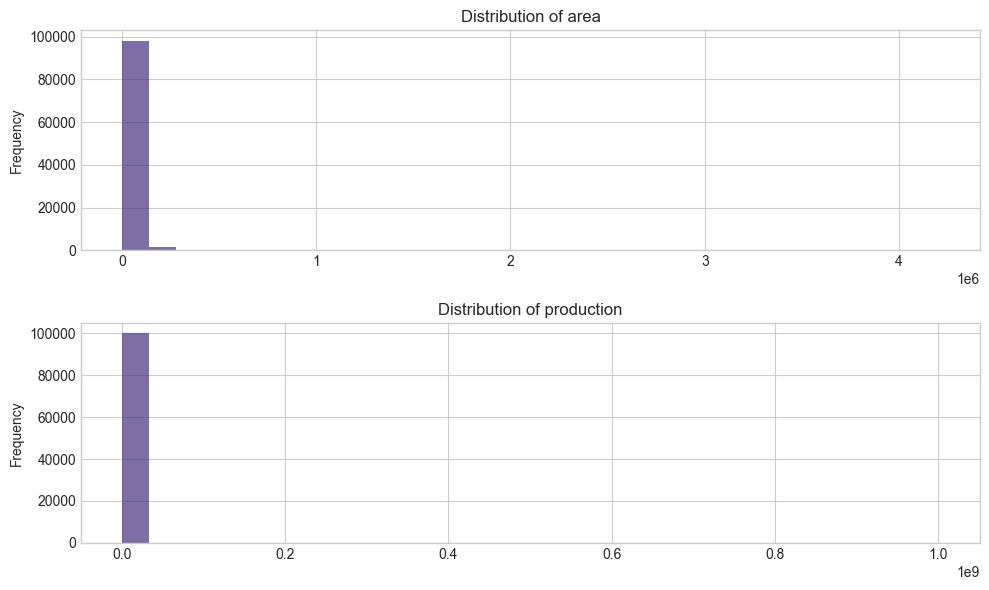


Creating bar charts for key categorical variables...
Skipping visualization for 'state_name' - too many categories (33)
Skipping visualization for 'district_name' - too many categories (646)


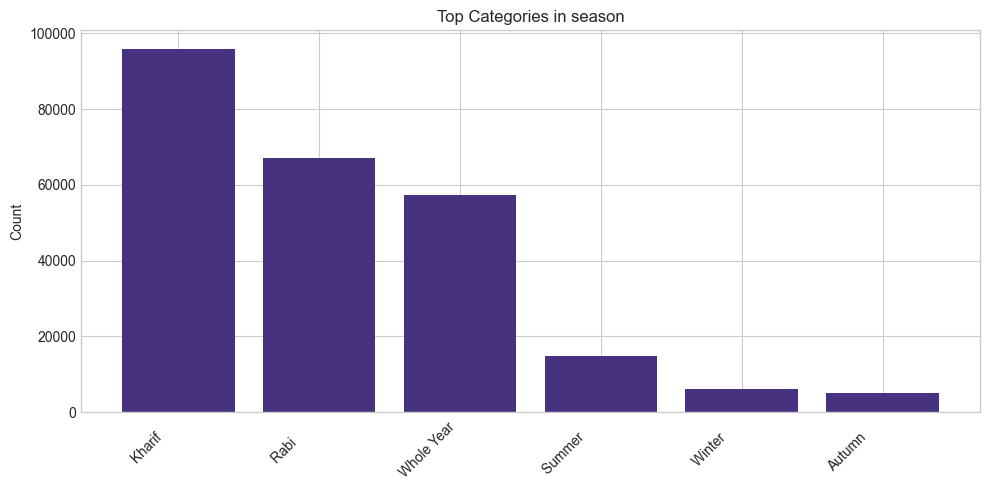


Creating correlation heatmap for key numeric variables...


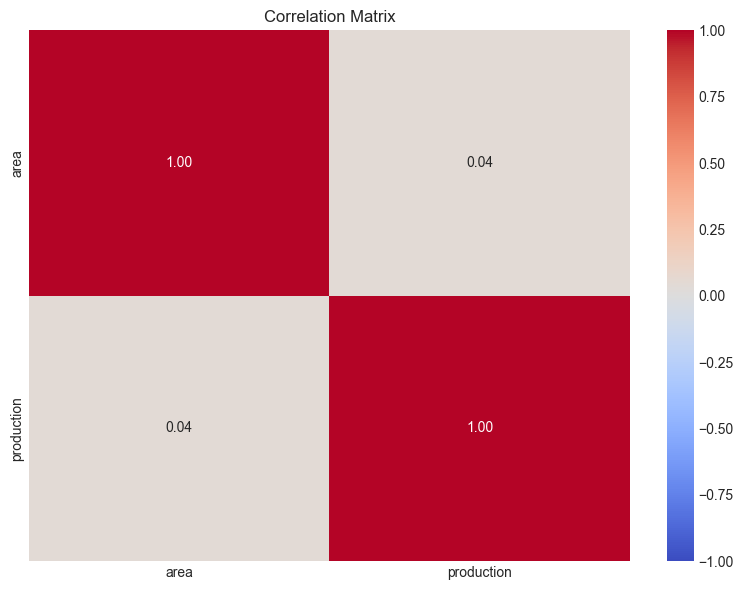


Creating time series plots...


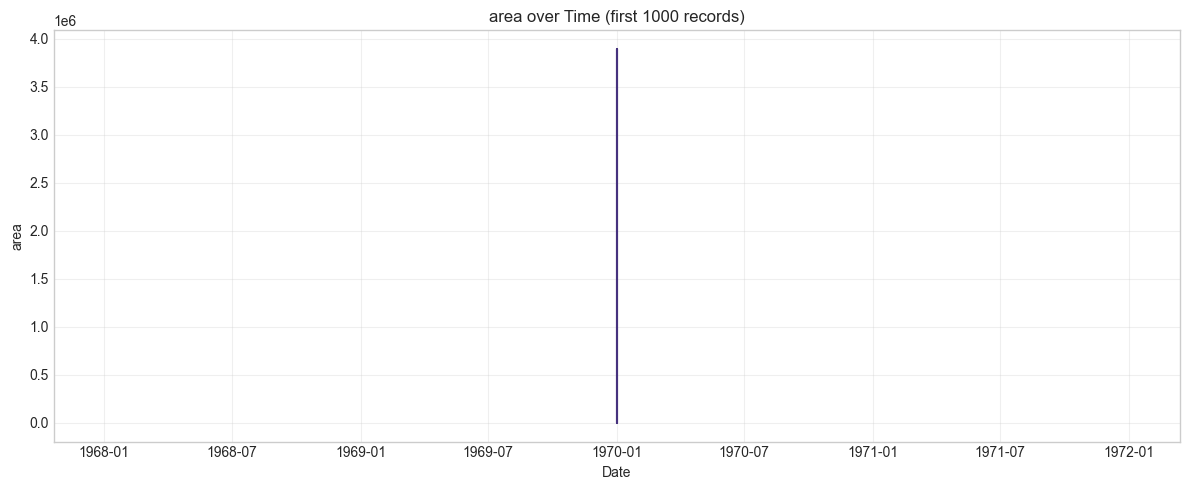

In [7]:
create_fast_visualizations(cleaned_data)

In [8]:
insights = generate_quick_insights(cleaned_data)
insights


----- QUICK DATA INSIGHTS -----

Key Insights:
1. Dataset contains 246091 records with 7 variables.
2. High-cardinality categorical variables that may need special handling: district_name (646 values), crop (124 values).
3. Time-series data spans 0 days from 1970-01-01 to 1970-01-01.


['Dataset contains 246091 records with 7 variables.',
 'High-cardinality categorical variables that may need special handling: district_name (646 values), crop (124 values).',
 'Time-series data spans 0 days from 1970-01-01 to 1970-01-01.']